## Домашнее задание №4
### Оптимизаторы

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = MNIST(root=".", train=True, transform=transform, download=True)
test_dataset = MNIST(root=".", train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

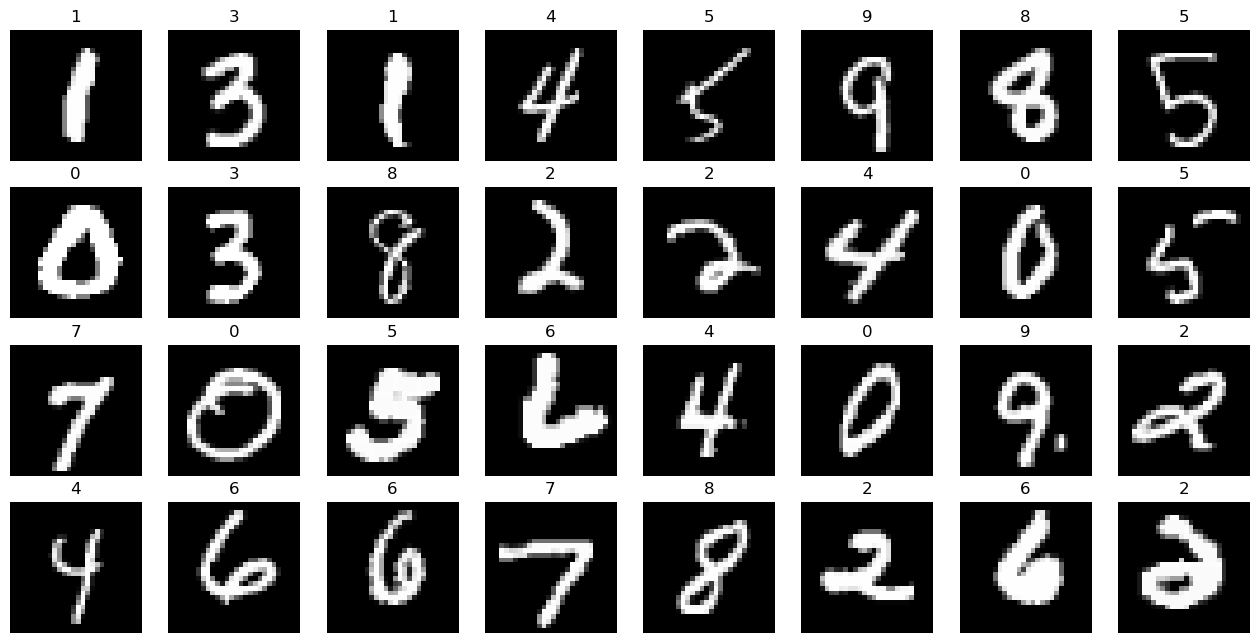

In [3]:
sample_idx = torch.randint(len(train_dataloader), size=(1,)).item()
for i, batch in enumerate(train_dataloader):
    figure = plt.figure(figsize=(16, 16))
    img, label = batch
    for j in range(img.shape[0]):
        figure.add_subplot(8, 8, j + 1)
        plt.imshow(img[j].squeeze(), cmap="gray")
        plt.title(label[j].item())
        plt.axis("off")

    plt.show()
    break

FFN model

In [4]:
class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Momentum

In [5]:
class MomentumOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9):
        super(MomentumOptimizer, self).__init__(params, defaults={"lr": lr})
        self.momentum = momentum
        self.state = dict()
        for group in self.param_groups:
            for p in group["params"]:
                self.state[p] = dict(mom=torch.zeros_like(p.data))

    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
                if p not in self.state:
                    self.state[p] = dict(mom=torch.zeros_like(p.data))
                mom = self.state[p]["mom"]
                mom = self.momentum * mom - group["lr"] * p.grad.data
                p.data += mom

Adam

In [6]:
class AdamOptimizer(torch.optim.Adam):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.999), weight_decay=0):
        super().__init__(params, lr=lr, betas=betas)
        self.weight_decay = weight_decay

    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients")

                state = self.state[p]

                if len(state) == 0:
                    state["step"] = 0
                    state["m_t"] = torch.zeros_like(p.data)
                    state["v_t"] = torch.zeros_like(p.data)

                m_t, v_t = state["m_t"], state["v_t"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                if self.weight_decay != 0:
                    grad = grad.add(p.data, alpha=self.weight_decay)

                m_t.mul_(beta1).add_(1 - beta1, grad)
                v_t.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = v_t.sqrt().add_(group["eps"])

                m_correction = 1 - beta1 ** state["step"]
                v_correction = 1 - beta2 ** state["step"]
                step_size = group["lr"] * np.sqrt(v_correction) / m_correction

                p.data.addcdiv_(-step_size, m_t, denom)

Adadelta

In [7]:
class AdadeltaOptimizer(torch.optim.Optimizer):
    def __init__(self, params, rho=0.9, eps=1e-6):
        defaults = dict(rho=rho, eps=eps)
        super(AdadeltaOptimizer, self).__init__(params, defaults)

    def step(self):

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]

                if "square_avg" not in state:
                    state["square_avg"] = torch.zeros_like(p.data)
                if "acc_delta" not in state:
                    state["acc_delta"] = torch.zeros_like(p.data)

                square_avg = state["square_avg"]
                acc_delta = state["acc_delta"]

                rho = group["rho"]
                eps = group["eps"]

                square_avg.mul_(rho).addcmul_(1 - rho, grad, grad)
                std = square_avg.add(eps).sqrt_()
                delta = acc_delta.add(eps).sqrt_().div_(std).mul_(grad)
                p.data.add_(-1, delta)

                acc_delta.mul_(rho).addcmul_(1 - rho, delta, delta)

In [8]:
def train(
    model,
    loss_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    n_epochs=10,
    device="cuda",
):
    accuracies, f1_scores, losses = [], [], []
    for epoch in range(n_epochs):
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            optimizer.zero_grad()

            x_train = x_train.to(device)
            y_train = y_train.to(device)

            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optimizer.step()

        # валидация
        val_loss = []
        val_accuracy = []
        val_f1_score = []
        targets = []
        preds = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = loss_fn(y_pred, y_val)
                _, predicted = torch.max(y_pred.data, 1)

                targets.extend(y_val.cpu().numpy().tolist())
                preds.extend(predicted.cpu().numpy().tolist())
                val_loss.append(loss.cpu().numpy())
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist()
                )

        accuracies.append(accuracy_score(targets, preds))
        f1_scores.append(f1_score(targets, preds, average="macro"))
        losses.append(np.mean(val_loss))

        print(
            f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}, f1_score: {f1_score(targets, preds, average="weighted")}'
        )

    return accuracies, f1_scores, losses

In [9]:
model = FFN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = MomentumOptimizer(model.parameters(), lr=0.001, momentum=0.9)

momentum_accuracy, momentum_f1_score, momentum_loss = train(
    model, loss_fn, optimizer, train_dataloader, test_dataloader, 10, device=device
)

100%|██████████| 313/313 [00:00<00:00, 344.65it/s]


Epoch: 0, loss: 1.4489256143569946, accuracy: 0.7149, f1_score: 0.6909841915923007


100%|██████████| 313/313 [00:01<00:00, 288.71it/s]


Epoch: 1, loss: 0.7013864517211914, accuracy: 0.8326, f1_score: 0.8302826547071304


100%|██████████| 313/313 [00:01<00:00, 290.48it/s]


Epoch: 2, loss: 0.5034469366073608, accuracy: 0.8676, f1_score: 0.8668259959887082


100%|██████████| 313/313 [00:01<00:00, 300.45it/s]


Epoch: 3, loss: 0.42570072412490845, accuracy: 0.884, f1_score: 0.8833638894334505


100%|██████████| 313/313 [00:01<00:00, 309.91it/s]


Epoch: 4, loss: 0.3823002278804779, accuracy: 0.8923, f1_score: 0.8916126864829137


100%|██████████| 313/313 [00:01<00:00, 275.73it/s]


Epoch: 5, loss: 0.35638687014579773, accuracy: 0.8983, f1_score: 0.8977795089303414


100%|██████████| 313/313 [00:01<00:00, 303.72it/s]


Epoch: 6, loss: 0.3391423225402832, accuracy: 0.9019, f1_score: 0.9016156337055414


100%|██████████| 313/313 [00:01<00:00, 208.22it/s]


Epoch: 7, loss: 0.3247239291667938, accuracy: 0.9065, f1_score: 0.9061547773359927


100%|██████████| 313/313 [00:01<00:00, 222.73it/s]


Epoch: 8, loss: 0.3144710063934326, accuracy: 0.9103, f1_score: 0.9101343282224907


100%|██████████| 313/313 [00:01<00:00, 285.90it/s]


Epoch: 9, loss: 0.3063478469848633, accuracy: 0.9104, f1_score: 0.9101770398782235


In [10]:
model = FFN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamOptimizer(model.parameters(), lr=3e-4, weight_decay=0.01)

adam_accuracy, adam_f1_score, adam_loss = train(
    model, loss_fn, optimizer, train_dataloader, test_dataloader, 10, device=device
)

100%|██████████| 313/313 [00:01<00:00, 257.13it/s]


Epoch: 0, loss: 0.25681063532829285, accuracy: 0.9278, f1_score: 0.9277059401842698


100%|██████████| 313/313 [00:01<00:00, 261.89it/s]


Epoch: 1, loss: 0.22474493086338043, accuracy: 0.9401, f1_score: 0.9401140934362371


100%|██████████| 313/313 [00:01<00:00, 250.57it/s]


Epoch: 2, loss: 0.19549527764320374, accuracy: 0.9431, f1_score: 0.9430385530958032


100%|██████████| 313/313 [00:01<00:00, 253.45it/s]


Epoch: 3, loss: 0.22083497047424316, accuracy: 0.9351, f1_score: 0.9355176057734849


100%|██████████| 313/313 [00:01<00:00, 255.63it/s]


Epoch: 4, loss: 0.174213707447052, accuracy: 0.9517, f1_score: 0.9516241475118106


100%|██████████| 313/313 [00:01<00:00, 268.50it/s]


Epoch: 5, loss: 0.16910482943058014, accuracy: 0.9537, f1_score: 0.9536441868261795


100%|██████████| 313/313 [00:01<00:00, 266.91it/s]


Epoch: 6, loss: 0.18175840377807617, accuracy: 0.9508, f1_score: 0.9507489914873055


100%|██████████| 313/313 [00:01<00:00, 265.55it/s]


Epoch: 7, loss: 0.18757684528827667, accuracy: 0.9469, f1_score: 0.9465994741247005


100%|██████████| 313/313 [00:01<00:00, 268.40it/s]


Epoch: 8, loss: 0.16532309353351593, accuracy: 0.9547, f1_score: 0.9545851297679646


100%|██████████| 313/313 [00:01<00:00, 254.00it/s]

Epoch: 9, loss: 0.17036940157413483, accuracy: 0.952, f1_score: 0.9518570765644028


In [11]:
model = FFN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdadeltaOptimizer(model.parameters())

adadelta_accuracy, adadelta_f1_score, adadelta_loss = train(
    model, loss_fn, optimizer, train_dataloader, test_dataloader, 10, device=device
)

100%|██████████| 313/313 [00:01<00:00, 248.85it/s]


Epoch: 0, loss: 0.2576603591442108, accuracy: 0.9244, f1_score: 0.9244470392148431


100%|██████████| 313/313 [00:01<00:00, 252.17it/s]


Epoch: 1, loss: 0.14545410871505737, accuracy: 0.9532, f1_score: 0.9533805296289191


100%|██████████| 313/313 [00:01<00:00, 244.90it/s]


Epoch: 2, loss: 0.1447688192129135, accuracy: 0.9651, f1_score: 0.9651595852785672


100%|██████████| 313/313 [00:01<00:00, 280.84it/s]


Epoch: 3, loss: 0.13359573483467102, accuracy: 0.9684, f1_score: 0.9683546742933968


100%|██████████| 313/313 [00:01<00:00, 278.23it/s]


Epoch: 4, loss: 0.12723277509212494, accuracy: 0.9675, f1_score: 0.9676642754275756


100%|██████████| 313/313 [00:01<00:00, 300.93it/s]


Epoch: 5, loss: 0.18690286576747894, accuracy: 0.9637, f1_score: 0.9636878339921187


100%|██████████| 313/313 [00:01<00:00, 293.88it/s]


Epoch: 6, loss: 0.16901715099811554, accuracy: 0.9667, f1_score: 0.9667101909078836


100%|██████████| 313/313 [00:01<00:00, 294.84it/s]


Epoch: 7, loss: 0.14815370738506317, accuracy: 0.972, f1_score: 0.9720172692711115


100%|██████████| 313/313 [00:01<00:00, 271.29it/s]


Epoch: 8, loss: 0.1592283695936203, accuracy: 0.9717, f1_score: 0.9717291120847497


100%|██████████| 313/313 [00:01<00:00, 273.03it/s]

Epoch: 9, loss: 0.17144925892353058, accuracy: 0.9699, f1_score: 0.9698830110895751


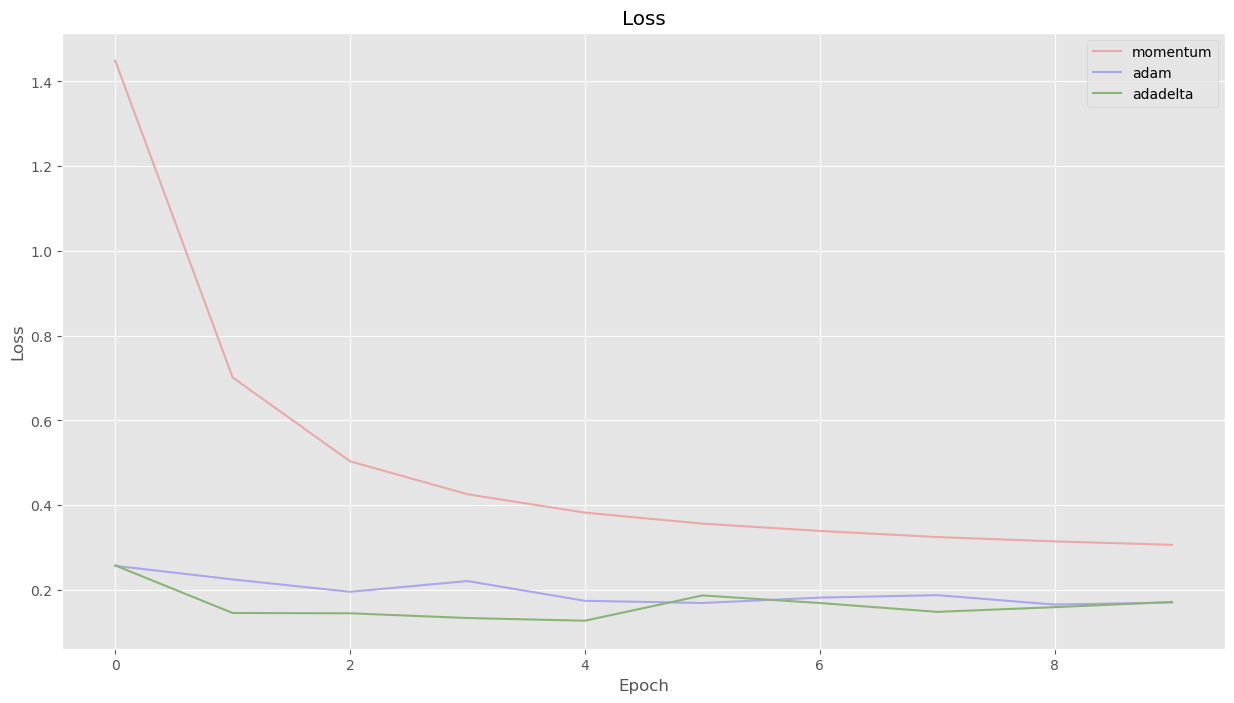

In [12]:
plt.figure(figsize=(15, 8))
plt.style.use("ggplot")
colors = [
    "#524a97",
    "#5877b2",
    "#5da4cd",
    "#e29954",
    "#91c5c0",
    "#c091c5",
    "#c59196",
    "#8ab475",
    "#a9a6e9",
    "#e9a9a6",
]

plt.plot(list(range(10)), momentum_loss, label="momentum", color=colors.pop())
plt.plot(list(range(10)), adam_loss, label="adam", color=colors.pop())
plt.plot(list(range(10)), adadelta_loss, label="adadelta", color=colors.pop())

plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

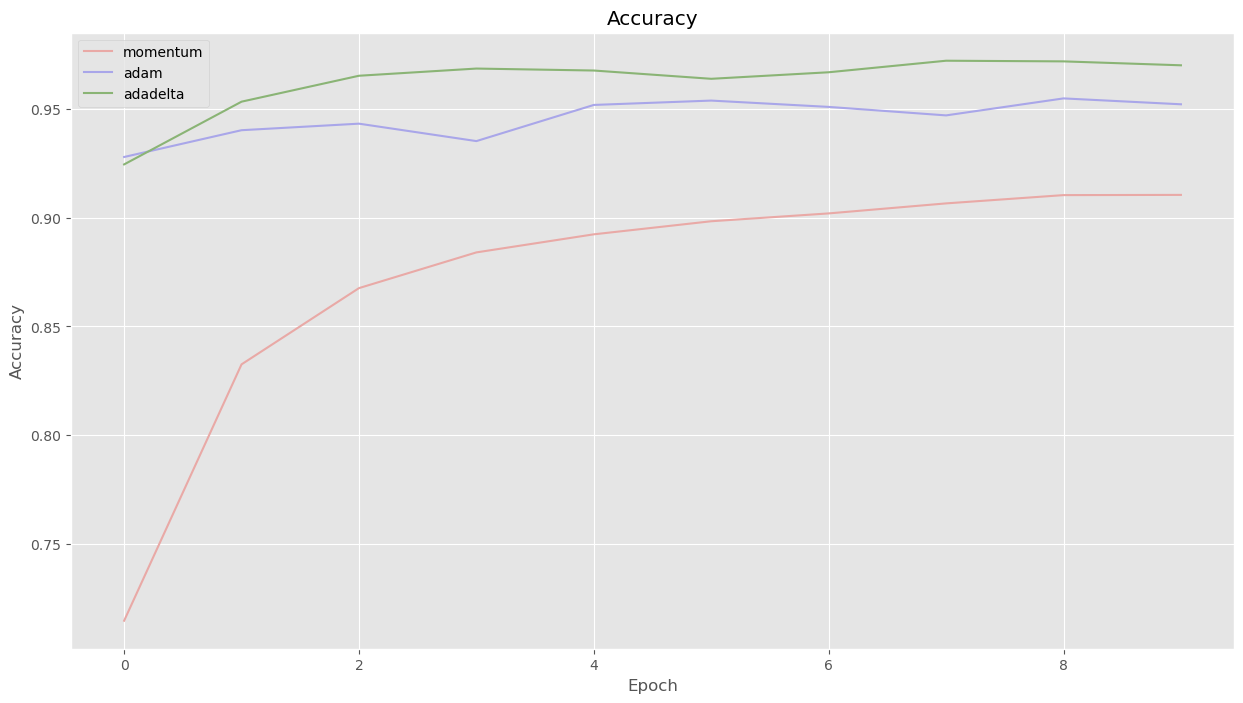

In [13]:
plt.figure(figsize=(15, 8))
plt.style.use("ggplot")
colors = [
    "#524a97",
    "#5877b2",
    "#5da4cd",
    "#e29954",
    "#91c5c0",
    "#c091c5",
    "#c59196",
    "#8ab475",
    "#a9a6e9",
    "#e9a9a6",
]

plt.plot(list(range(10)), momentum_accuracy, label="momentum", color=colors.pop())
plt.plot(list(range(10)), adam_accuracy, label="adam", color=colors.pop())
plt.plot(list(range(10)), adadelta_accuracy, label="adadelta", color=colors.pop())

plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

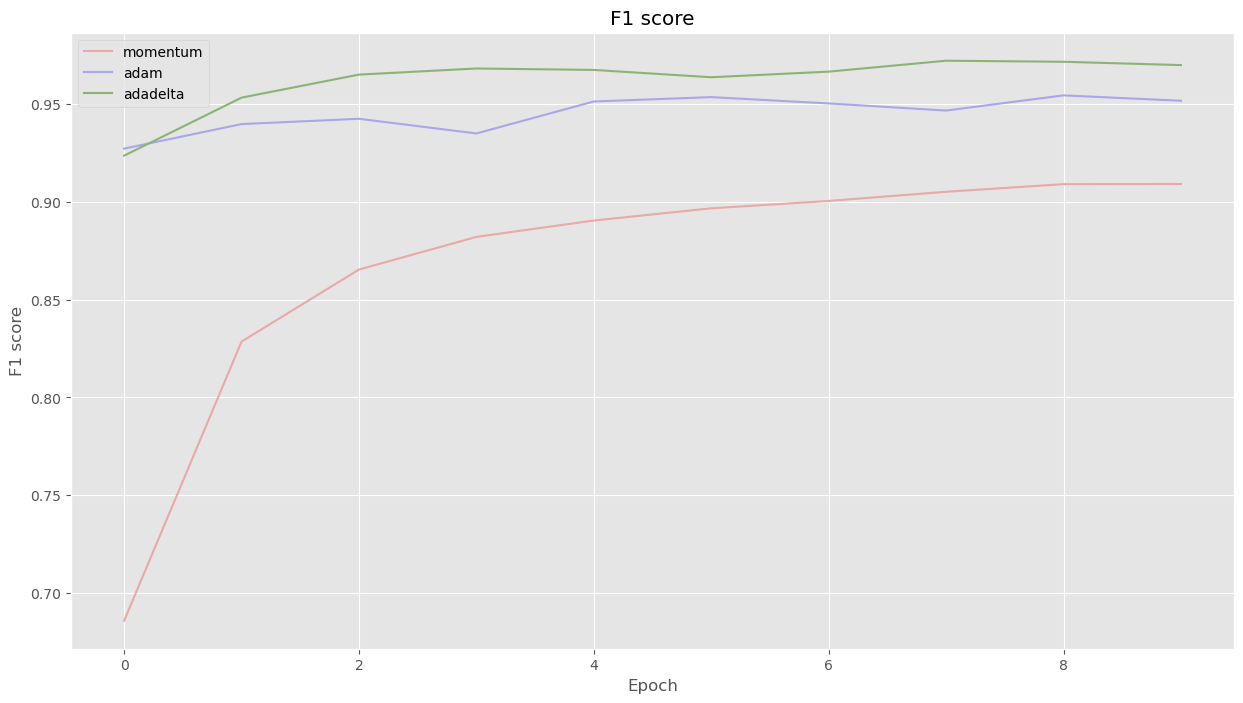

In [14]:
plt.figure(figsize=(15, 8))
plt.style.use("ggplot")
colors = [
    "#524a97",
    "#5877b2",
    "#5da4cd",
    "#e29954",
    "#91c5c0",
    "#c091c5",
    "#c59196",
    "#8ab475",
    "#a9a6e9",
    "#e9a9a6",
]

plt.plot(list(range(10)), momentum_f1_score, label="momentum", color=colors.pop())
plt.plot(list(range(10)), adam_f1_score, label="adam", color=colors.pop())
plt.plot(list(range(10)), adadelta_f1_score, label="adadelta", color=colors.pop())

plt.legend()
plt.title("F1 score")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.show()

Выводы:
- Алгоритм SGD+Momentum показал наихудшие показатели по лоссу и метрикам, а также он сходится дольше, чем Adam и Adadelta. 
- Сравнивая Adam и Adadelta, второй обеспечил более быструю сходимость и лучшие результаты по метрикам, однако лосс ведет себя чуть более нестабильнее, чем у Adam